Let's start off by loading the packages we are going to need for this tutorial. This step will take a while because Julia has to compile each package.

If you don't have these packages installed you can install them by first:
import Pkg
Pkg.add("Turing")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("DataFrames")

In [5]:
using Plots, StatsPlots;
using Turing;
using DataFrames;

Now we want to define a quick helper function to help us extract parameters from the MCMC chains that we'll run later.

In [6]:
function extract(chain, sym; burn=0, is_scalar=true)
    if is_scalar
        tail = chain[sym].data[(burn + 1):end, 1]
    else
        tail = group(chain, sym).value.data[(burn + 1):end, :, 1]
    end
    return tail
end

extract (generic function with 1 method)

Our data consists of the same experiment being repeated multiple times:
|    Exp. #   | #Successes  |   #Trials  |
| :---        |    :----:   |       ---: |
|      1      |      1      |     2      |
|      2      |      2      |     4      |
|      3      |      0      |     1      |
|      4      |      3      |     5      |

The goal of our analysis will be to answer the following questions:
1. What is the probability of success in each experiment?
2. Can they all be treated as similar?

Question 1. 
The probability of success is the parameter that we want to determine for each experiment - ρ
Since we have 4 experiments we have ρ1, ρ2, ρ3, and ρ4

In order to determine the value for each parameter we want to perform a Bayesian analysis - that is we want to combine our data with some prior knowledge.  

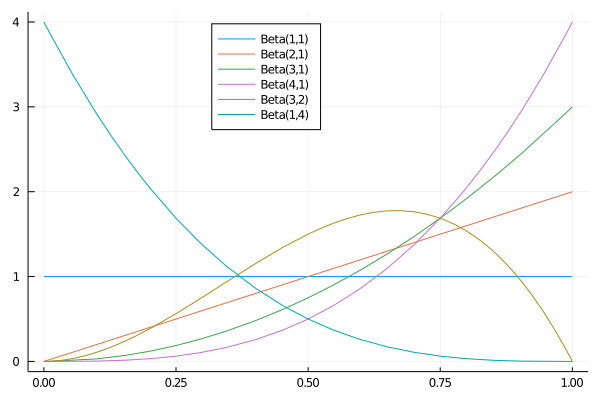

In [23]:
plot(Beta(1,1), label="Beta(1,1)")
plot!(Beta(2,1), label="Beta(2,1)")
plot!(Beta(3,1), label="Beta(3,1)")
plot!(Beta(4,1), label="Beta(4,1)")
plot!(Beta(3,2), label="Beta(3,2)")
plot!(Beta(1,4), label="Beta(1,4)", legend=:top)

In our model we had an experiment that was repeated a few times and for each experiment we have know how many successful trials (y[i]) there were and how many total trials (n[i]). In order to compute this model we're going to need to loop over all the observations so first we get the length and store it in nobs.

Then we apply the priors for our parametrization which we draw from a Normal distribution with a mean of 0 and standard deviation of 1. Since αz represents the parameters for each experiment we need to apply a 'trick' to efficiently apply a prior to our list of observations. We do this by wrapping filldist() around the Normal(0, 1) call and telling it how many experiments we have (nobs). This is more efficient than looping over a range.

The final part is to compare our model to the data. This is done in a for loop since each data point is compared to a slightly different distribution

In [7]:
@model hierachicalBetaBinomial(y, n) = begin
    nobs = length(y)
    μ ~ Normal(0,1)
    𝜏 ~ Normal(0,1)
    αz ~ filldist(Normal(0,1), nobs)
    α =  μ .+ αz*𝜏
    for i = 1:nobs
        y[i] ~ BinomialLogit(n[i], α[i])
    end
end

hbb (generic function with 1 method)